In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
sns.set_style("whitegrid")


In [2]:
def get_trial_results(dataset,trials):
        
    results=[]
    re_string="val_loss: ([\w\.]+) - val_psnr: ([\w\.]+) - val_ssim: ([\w\.]+)"
    for r in range(5):
        file=f"/data1/s1620444/logs/autosr/autosr_{dataset}_v1_{trials}_{r}.txt"

        with open(file,"r") as f:
            lines=f.readlines()
            indices=[i-3 for i,s in enumerate(lines) if "Complete" in s]

        results.extend([[r,i,float(match[0]),float(match[1]),float(match[2])] for i,id in enumerate(indices) for match in re.findall(re_string,lines[id])])
    df = pd.DataFrame(results,columns=["run","trial","val_loss","val_psnr","val_ssim"])
    df=df.dropna()

    return df[(df["val_psnr"]>0)]

In [3]:
# get scores per trial and save to csv
results=get_trial_results("cerrado",100)
results.to_csv("/data1/s1620444/results/autosr/cerrado_100_trials.csv")
results=get_trial_results("sent_nicfi",50)
results.to_csv("/data1/s1620444/results/autosr/sent_nicfi_50_trials.csv")

In [6]:
# load baseline val scores
df_baselines=pd.read_csv("/data1/s1620444/results/baselines/val_results.csv", header=0)
baseline_mean= df_baselines.groupby(["baseline","dataset"]).mean()
baseline_std= df_baselines.groupby(["baseline","dataset"]).std()

In [9]:
psnr_rcan=baseline_mean.query('baseline=="rcan"&dataset=="cerrado"')["val_psnr"][0]
std_rcan=baseline_std.query('baseline=="rcan"&dataset=="cerrado"')["val_psnr"][0]
psnr_wdsr=baseline_mean.query('baseline=="wdsr"&dataset=="cerrado"')["val_psnr"][0]
std_wdsr=baseline_std.query('baseline=="wdsr"&dataset=="cerrado"')["val_psnr"][0]

<h2> Plot ideas </h2>
<ul>
<li> histogram idee </li>
<li> sliding window </li>
</ul>

<h2> All datapoints </h2>

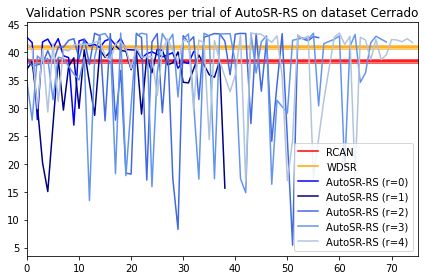

In [20]:
# plot: scatter, psnr as function of trials
import numpy as np
colors=["blue", "navy", "royalblue","cornflowerblue","lightsteelblue"]
fig,ax=plt.subplots()
x = np.linspace(0,80,50)
ax.axhline(psnr_rcan,label="RCAN",color="r")
ax.fill_between(x, psnr_rcan-std_rcan,psnr_rcan+std_rcan,alpha=0.5,color="r")
ax.axhline(psnr_wdsr,label="WDSR",color="orange")
ax.fill_between(x, psnr_wdsr-std_wdsr,psnr_wdsr+std_wdsr,alpha=0.5,color="orange")
for r in range(5):
    run_results=results.loc[results.run==r].dropna()
    ax.plot(run_results["trial"].to_numpy(),run_results["val_psnr"].to_numpy(),color=colors[r],label=f"AutoSR-RS (r={r})")
# ax.set_yticks(np.linspace(25,45,20))
# ax.set_yticks([round(num,2) for num in np.linspace(25,45,20)])
ax.set_xlim(0,75)
plt.title("Validation PSNR scores per trial of AutoSR-RS on dataset Cerrado")
plt.legend()
plt.tight_layout()
plt.show()


<h2> Elitist selection </h2>

In [10]:
# plot best result until now
from functools import partial
def get_best_psnr(df,x):
    trial=x.trial
    run=x.run
    return df.loc[(df.run==run) & (df.trial <=trial)]["val_psnr"].max()

get_best=partial(get_best_psnr, results)
results["elitist_psnr"]=results.apply(get_best,axis=1)

In [30]:
results

,run,trial,val_loss,val_psnr,val_ssim,elitist_psnr
0,0,0,1.3613,42.6907,0.9771,42.6907
1,0,1,1.5085,41.7586,0.9741,42.6907
2,0,2,8.4051,27.9490,0.5882,42.6907
3,0,3,1.4682,41.8764,0.9751,42.6907
4,0,4,1.4024,42.3865,0.9761,42.6907
...,...,...,...,...,...,...
265,4,70,1.4092,42.3113,0.9763,43.4800
266,4,71,1.4311,42.2285,0.9756,43.4800
267,4,72,1.4676,41.9112,0.9750,43.4800
268,4,73,1.3968,42.4672,0.9763,43.4800


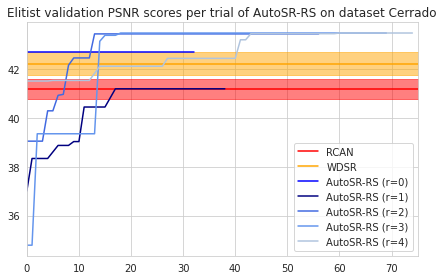

In [11]:
# plot: scatter, psnr as function of trials
import numpy as np
colors=["blue", "navy", "royalblue","cornflowerblue","lightsteelblue"]
fig,ax=plt.subplots()
x = np.linspace(0,80,50)
ax.axhline(psnr_rcan,label="RCAN",color="r")
ax.fill_between(x, psnr_rcan-std_rcan,psnr_rcan+std_rcan,alpha=0.5,color="r")
ax.axhline(psnr_wdsr,label="WDSR",color="orange")
ax.fill_between(x, psnr_wdsr-std_wdsr,psnr_wdsr+std_wdsr,alpha=0.5,color="orange")
for r in range(5):
    run_results=results.loc[results.run==r].dropna()
    ax.plot(run_results["trial"].to_numpy(),run_results["elitist_psnr"].to_numpy(),color=colors[r],label=f"AutoSR-RS (r={r})")
# ax.set_yticks(np.linspace(25,45,20))
# ax.set_yticks([round(num,2) for num in np.linspace(25,45,20)])
ax.set_xlim(0,75)
plt.title("Elitist validation PSNR scores per trial of AutoSR-RS on dataset Cerrado")
plt.legend()
plt.tight_layout()
plt.show()

<h2> Elitist with error bands </h2<

In [12]:
# get mean elitist with min/max band
# option: color code number of runs per point

def get_elitist_mean_min_max_func(results,x):
    trial=x.trial
    psnr_scores=results.loc[(results.trial==trial)]["val_psnr"]
    return psnr_scores.mean(),psnr_scores.min(),psnr_scores.max()

get_elitist_mean_min_max=partial(get_elitist_mean_min_max_func,results)

results[["elitist_mean","elitist_min","elitist_max"]]=results.apply(get_elitist_mean_min_max,axis=1,result_type="expand")
group_elite_mean= results.groupby(["trial"]).first()

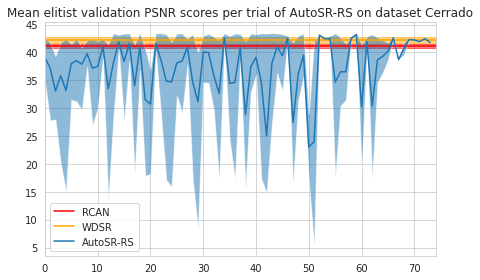

In [13]:
colors=["blue", "navy", "royalblue","cornflowerblue","lightsteelblue"]
fig,ax=plt.subplots()
x = np.linspace(0,80,50)
ax.axhline(psnr_rcan,label="RCAN",color="r")
ax.fill_between(x, psnr_rcan-std_rcan,psnr_rcan+std_rcan,alpha=0.5,color="r")
ax.axhline(psnr_wdsr,label="WDSR",color="orange")
ax.fill_between(x, psnr_wdsr-std_wdsr,psnr_wdsr+std_wdsr,alpha=0.5,color="orange")
ax.plot(np.arange(0,results["trial"].max()),group_elite_mean["elitist_mean"],label=f"AutoSR-RS")
ax.fill_between(np.arange(0,results["trial"].max()),group_elite_mean["elitist_min"], group_elite_mean["elitist_max"],alpha=0.5)
ax.set_xlim(0,74)
plt.title("Mean elitist validation PSNR scores per trial of AutoSR-RS on dataset Cerrado")
plt.legend()
plt.tight_layout()
plt.show()